In [54]:
# Make your plot output stored in the notebook.
%matplotlib inline

from fintextmin import *

import pandas
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

df = pandas.read_csv('apple_jobs.csv',encoding='iso-8859-1')
df.head(10)

,title,location,minimum_qual,preferred_qual,responsibilities,education&experience
0,Software Technician,"Santa Clara Valley (Cupertino), California, Un...",2-5 years experience supporting or deploying a...,NaN,"As a software techician, you will assist with ...","AS/BS in Information Technology, or equivalent"
1,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",KEY QUALIFICATIONS\nA genuine passion for fixi...,ADDITIONAL REQUIREMENTS\nReal hands-on experie...,DESCRIPTION\nWork with multi-functional teams ...,EDUCATION\nBS or MS in Computer Engineering or...
2,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",- 3+ years experience working on large scale d...,NaN,"This position will design, implement and debug...","BS, MS or PhD, in Computer Science, or equival..."
3,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",- 3+ years experience working on large scale d...,NaN,"This position will design, implement and debug...","BS, MS or PhD, in Computer Science, or equival..."
4,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",Demonstrated experience integrating full-syste...,NaN,"Extraordinary planning, critical thinking, and...","M.S. or PhD in Computer Science, Electrical En..."
5,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",A successful track-record and proven experienc...,NaN,"We are building, and supporting new, critical ...",BS or MS in Computer Science or equivalent wor...
6,Software Engineer,"Austin, Texas, United States",Passion to create amazing products which users...,NaN,JOB SUMMARY\nImagine what you could do here to...,A BS/MS/PhD in Electrical or Computer Engineer...
7,Software Engineer,"Hyderabad, Telangana, India",In-depth understanding of data structures and ...,NaN,Design and build data pipelines on MPP platfor...,Bachelor?s Degree or Equivalent with 2+ years...
8,Software Engineer,"Austin, Texas, United States",Passion to create amazing products which users...,NaN,JOB SUMMARY\nImagine what you could do here to...,A BS/MS/PhD in Electrical or Computer Engineer...
9,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",2-7 years experience developing system softwar...,Experience designing SW interfaces or APIs is ...,HID Software is looking for an engineer to wor...,BS/MS in CS/CE (or equivalent)


## 1. Degree Requirements

In [55]:
def count_keywords_freq(df: pandas.DataFrame, col_name: str, keywords: list, case_sensitive=True):
    """ Given a list of keywords and count their frequency in
    the specified pandas dataframe.
    :param d: target pandas dataframe.
    :param col_name: target column name.
    :param keywords: a list of keywords.
    :param case_sensitive: either True or False.
    :return: keyword frequency dict.
    """
    freq_dict = {keyword: 0 for keyword in keywords}
    freq_dict['None'] = 0
    
    for col in list(df[col_name]):
        if type(col) is not str:
            continue
        if case_sensitive is False:
            col = col.lower()
        lines = col.rstrip().split('\n')
        no_degree_req = True
        for line in lines:
            for keyword in keywords:
                if keyword in line:
                    freq_dict[keyword] += 1
                    no_degree_req = False
        if no_degree_req:
            freq_dict['None'] += 1
                    
    return freq_dict

In [56]:
keywords = ['PhD', 'Master', 'MBA', 'BA', 'BS', 'Bachelor']

# Count keyword frequency.
degree_reqs = count_keywords_freq(df, 'education&experience', keywords)

print("Education & Experience: " + str(degree_reqs))

Education & Experience: {'PhD': 250, 'Master': 249, 'MBA': 60, 'BA': 139, 'BS': 1054, 'Bachelor': 460, 'None': 385}


In [57]:
degree_df = pandas.DataFrame.from_dict(education, orient='index', columns=['Count'])

degree_df

,Count
PhD,258
Master,259
MBA,66
BA,151
BS,1096
Bachelor,469
None,322


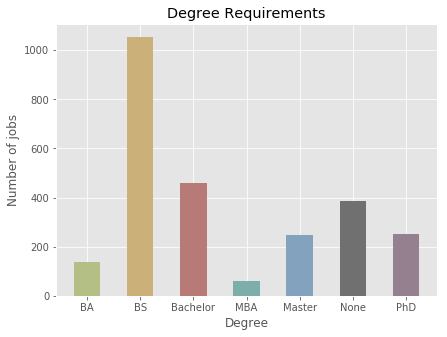

In [58]:
colors = ['#958090', '#83A2BE', '#7DAEA9', '#B4BF86', '#CBB079', '#B77A76', '#707070', '#AAAAAA']

degree_labels = list(degree_reqs.keys())
degree_values = list(degree_reqs.values())

plt.figure(figsize=(15, 5))

# In this plot, there will be 1 row, 2 columns.
plt.subplot(1, 2, 1) # Drawing the 1st subplot.
plt.bar(degree_labels, degree_values, color=colors, width=0.5)
plt.xlabel('Degree')
plt.ylabel('Number of jobs')
plt.title('Degree Requirements')

plt.show()

## 2.Experience Requirements

In [66]:
def extract_experience(df: pandas.DataFrame, col_name: str, start_year=0, end_year=25):
    """ Extract years of experiences required
    :param df: target dataframe.
    :param col_name: name of the column that contains strings
                     like `4 years of experience in ...`
    :param start_year: the starting year in the list returned.
    :param end_year: the last year in the list returned.
    :return: a list of years of exp required (index by years)
    """
    import re
    
    exp_list = [0] * 26
    
    for col in df[col_name]:
        exp_required = re.findall('\d+ year', col)
        year = 0 if not exp_required else int(exp_required[0].replace(' year', ''))
        exp_list[year] += 1
        
    return exp_list

In [67]:
min_exp_list = extract_experience(df, 'minimum_qual')

TypeError: expected string or bytes-like object

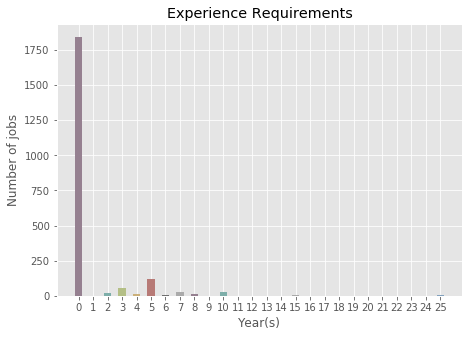

In [68]:
colors = ['#958090', '#83A2BE', '#7DAEA9', '#B4BF86', '#CBB079', '#B77A76', '#707070', '#AAAAAA']
labels = np.arange(len(min_exp_list))

plt.figure(figsize=(16, 5))

# In this plot, there will be 1 row, 2 columns.
plt.subplot(1, 2, 1) # Drawing the 1st subplot.
plt.bar(np.arange(26), min_exp_list[0:26], color=colors, width=0.5)
plt.xticks(labels[0:26])
plt.xlabel('Year(s)')
plt.ylabel('Number of jobs')
plt.title('Experience Requirements')

plt.show()

## 3. Top 8 Job Titles

In [69]:
jobs_freq = {}

for col in df['title']:
    if type(col) is not str:
        continue
    col = col.split(',')[0]
    if col in jobs_freq:
        jobs_freq[col] += 1
    else:
        jobs_freq[col] = 1
        
jobs_freq = dict(sorted(jobs_freq.items(), key=lambda kv: kv[1], reverse=True))

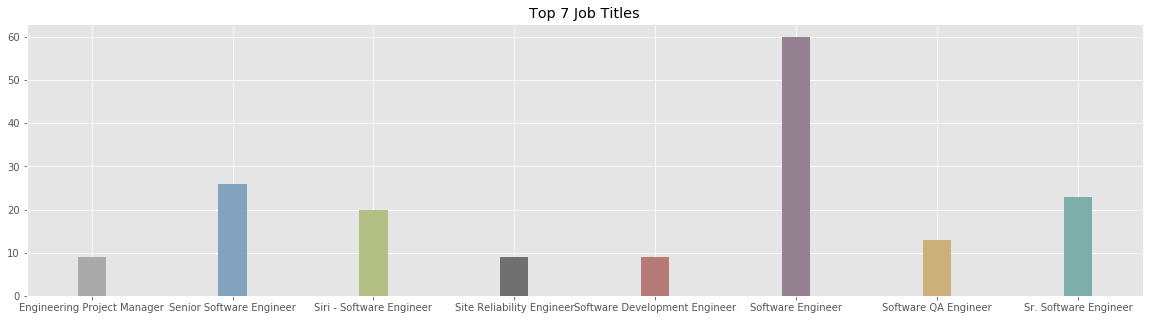

In [70]:
colors = ['#958090', '#83A2BE', '#7DAEA9', '#B4BF86', '#CBB079', '#B77A76', '#707070', '#AAAAAA']

min_labels = list(jobs_freq.keys())[0:8]
min_values = list(jobs_freq.values())[0:8]

plt.figure(figsize=(20, 5))
plt.bar(min_labels, min_values, color=colors, width=0.2)
plt.title('Top 7 Job Titles')
plt.show()

## 4. Top 10 Programming Languages

In [71]:
lang_colors = {
    'c++': '#F34B7D',
    'java': '#B07219',
    'python': '#3572A5',
    'javascript': '#F1E05A',
    'go': '#375EAB',
    'rust': '#DEA584',
    'php': '#4F5D95',
    'sql': '#494D5C',
    'ruby': '#701516',
    'swift': '#FFAC45',
    'kotlin': '#F18E33',
    'c#': '#178600',
    'objective c': '#438EFF'
}

In [72]:
langs = lang_colors.keys()

# Count keyword frequency.
min_lang_reqs = count_keywords_freq(df, 'minimum_qual', langs, case_sensitive=False)
pref_lang_reqs = count_keywords_freq(df, 'preferred_qual', langs, case_sensitive=False)

del min_lang_reqs['None']
del pref_lang_reqs['None']

# Sort the dicts.
min_lang_reqs = dict(sorted(min_lang_reqs.items(), key=lambda kv: kv[1], reverse=True))
pref_lang_reqs = dict(sorted(pref_lang_reqs.items(), key=lambda kv: kv[1], reverse=True))

# Create DataFrame from dict.
min_lang_df = pandas.DataFrame.from_dict(min_lang_reqs, orient='index', columns=['Count'])
pref_lang_df = pandas.DataFrame.from_dict(pref_lang_reqs, orient='index', columns=['Count'])

min_lang_reqs

{'c#': 15,
 'c++': 637,
 'go': 942,
 'java': 743,
 'javascript': 247,
 'kotlin': 2,
 'objective c': 34,
 'php': 38,
 'python': 686,
 'ruby': 142,
 'rust': 64,
 'sql': 331,
 'swift': 207}

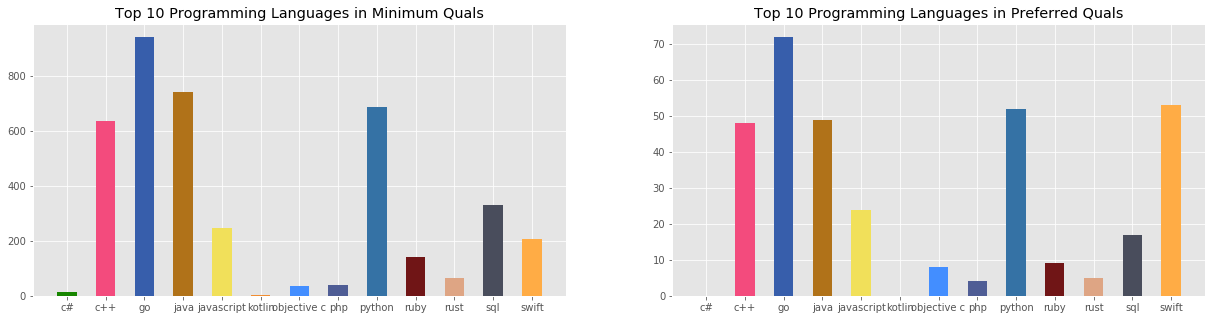

In [73]:
min_labels = list(min_lang_reqs.keys())
min_values = list(min_lang_reqs.values())
min_colors = [lang_colors[k] for k, v in min_lang_reqs.items()]

pref_labels = list(pref_lang_reqs.keys())
pref_values = list(pref_lang_reqs.values())
pref_colors = [lang_colors[k] for k, v in pref_lang_reqs.items()]


plt.figure(figsize=(21, 5))

# In this plot, there will be 1 row, 2 columns.
plt.subplot(1, 2, 1) # Drawing the 1st subplot.
plt.bar(min_labels, min_values, color=min_colors, width=0.5)
plt.title('Top 10 Programming Languages in Minimum Quals')

plt.subplot(1, 2, 2) # Drawing the 2nd subplot.
plt.bar(pref_labels, pref_values, color=pref_colors, width=0.5)
plt.title('Top 10 Programming Languages in Preferred Quals')

plt.show()

## 5. Top 5 Most Demanding Skills from Job Descriptions

Extract keywords and create word clouds from the following:

● Minimum Qualifications

● Preferred Qualifications

● Responsibilities

### Word frequency matrix

For each job, we create a wfm (word frequency matrix) and store all results in a dict.

In [74]:
def remove_puncs(s):
    """ Replace each puncutations in string s with a whitespace """
    return re.sub(r'([^\s\w]|_)+', ' ', s).strip()

In [75]:
def remove_digits(s):
    """ Replace all digits from string s """
    return re.sub(r'\d+', ' ', s).strip()

In [76]:
def create_word_freq_dict(df: pandas.DataFrame, col_name: str):
    """ Create a word frequency dict
    :param df: source pandas dataframe.
    :param col_name: name of the column to create wfm from.
    :return: a word frequency dict (dict of dict, separated by job indices).
    """
    freq_dict = {}
    
    for i, col in enumerate(df[col_name]):
        if type(col) is not str:
            continue
        freq_dict[i] = {}
        
        cleaned_string = remove_puncs(remove_digits(col)).replace('\n', ' ')
        words = cleaned_string.split()
        for word in words:
            if word in freq_dict:
                freq_dict[i][word] += 1
            else:
                freq_dict[i][word] = 1
                
    return freq_dict

In [77]:
def create_wfm(word_frequency_dict: dict):
    """ Create word frequency matrix from the specified word frequency dict """
    dwf_list = [pandas.DataFrame(list(freq.values()), index=freq.keys()) for freq in word_frequency_dict.values()]
    wfm = pandas.concat(dwf_list, axis=1)
    wfm = np.transpose(wfm).fillna(0)
    wfm.index = word_frequency_dict.keys()
    return wfm

In [78]:
min_qual_wfd = create_word_freq_dict(df, 'minimum_qual')
pref_qual_wfd = create_word_freq_dict(df, 'preferred_qual')
resp_qual_wfd = create_word_freq_dict(df, 'responsibilities')

list(min_qual_wfd[0].items())[0:10]

[('years', 1),
 ('experience', 1),
 ('supporting', 1),
 ('or', 1),
 ('deploying', 1),
 ('application', 1),
 ('software', 1),
 ('for', 1),
 ('internal', 1),
 ('and', 1)]

In [79]:
min_qual_wfm = create_wfm(min_qual_wfd)
pref_qual_wfm = create_wfm(pref_qual_wfd)
resp_wfm = create_wfm(resp_qual_wfd)

# Row: job, Column: word frequency
min_qual_wfm.head()

C:\Users\Anita\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,A,AAA,AAC,ABAP,ABAQUS,ABILITY,AC,ACL,ACPI,ACS,...,è,èµ,è½,è½½,è¾,è¾¾,é,éª,ï,ï¼
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Apply TF-IDF Transformation to Word Frequency Matrices

In [80]:
def create_tfm(wfm):
    tfm = wfm.copy()
    for i in range(0, len(tfm)):
        tfm.iloc[i] = tfm.iloc[i] / tfm.iloc[i].sum()
    return tfm

min_qual_tfm = create_tfm(min_qual_wfm)
pref_qual_tfm = create_tfm(pref_qual_wfm)
resp_tfm = create_tfm(resp_wfm)

min_qual_tfm.head()

,A,AAA,AAC,ABAP,ABAQUS,ABILITY,AC,ACL,ACPI,ACS,...,è,èµ,è½,è½½,è¾,è¾¾,é,éª,ï,ï¼
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.012821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
min_qual_df = (min_qual_wfm > 0).sum()
pref_qual_df = (pref_qual_wfm > 0).sum()
resp_df = (resp_wfm > 0).sum()

In [82]:
N = len(df)
N

2157

In [85]:
def create_tfidfm(tfm, N, df):
    tfidfm = tfm.copy()
    for i in range(0, len(tfidfm)):
        tfidfm.iloc[i] = tfidfm.iloc[i] * np.log10(N / df) + 1
    return tfidfm
    
min_qual_tfidfm = create_tfidfm(min_qual_tfm, N, min_qual_df)
pref_qual_tfidfm = create_tfidfm(pref_qual_tfm, N, pref_qual_df)
resp_tfidfm = create_tfidfm(resp_tfm, N, resp_df)

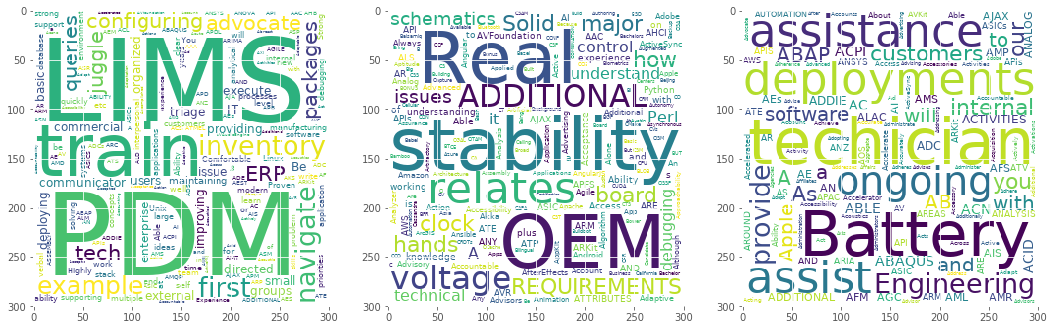

In [86]:
font_path = r'DejaVuSans.ttf'

plt.figure(figsize=(18, 6))

# Minimum Qualification Word Cloud
ax1 = plt.subplot(131)
plot_tfidf_wordcloud(min_qual_tfidfm, text_index=0, ax=ax1, font_path=font_path, height=300, width=300)

# Preferred Qualification Word Cloud
ax2 = plt.subplot(132)
plot_tfidf_wordcloud(pref_qual_tfidfm, text_index=0, ax=ax2, font_path=font_path, height=300, width=300)

# Responsibilities Word Cloud
ax3 = plt.subplot(133)
plot_tfidf_wordcloud(resp_tfidfm, text_index=0, ax=ax3, font_path=font_path, height=300, width=300)